In [71]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython tensorflow_addons opencv-python requests

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Variational Autoencoder

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/VAE/vae-gaussian.png">

We're trying to build a generative model here, not just a fuzzy data structure that can "memorize" images. We can't generate anything yet, since we don't know how to create latent vectors other than encoding them from images.

There's a simple solution here. We add a constraint on the encoding network, that forces it to generate latent vectors that roughly follow a unit gaussian distribution. It is this constraint that separates a variational autoencoder from a standard one.

Generating new images is now easy: all we need to do is sample a latent vector from the unit gaussian and pass it into the decoder.

In practice, there's a tradeoff between how accurate our network can be and how close its latent variables can match the unit gaussian distribution.

We let the network decide this itself. For our loss term, we sum up two separate losses: the generative loss, which is a mean squared error that measures how accurately the network reconstructed the images, and a latent loss, which is the KL divergence that measures how closely the latent variables match a unit gaussian. [ref](http://kvfrans.com/variational-autoencoders-explained/)

## Code

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
%matplotlib inline

In [73]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
batch_size = 128
epochs = 50

# Network Parameters
hidden_1 = 128 # 1st layer num features.
hidden_2 = 64 # 2nd layer num features (the latent dim).

In [74]:
from tensorflow.keras.datasets import mnist, fashion_mnist

def load_data(choice='mnist', labels=False):
    if choice not in ['mnist', 'fashion_mnist']:
        raise ('Choices are mnist and fashion_mnist')

    if choice is 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    X_train, X_test = X_train / 255., X_test / 255.
    X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])
    X_train = X_train.astype(np.float32, copy=False)
    X_test = X_test.astype(np.float32, copy=False)

    if labels:
        return (X_train, y_train), (X_test, y_test)

    return X_train, X_test

def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (28, 28)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (28, 28)), aspect='auto')
    plt.tight_layout()

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-74-47545c9b4cc5>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if choice is 'mnist':


In [75]:
def plot_digits(X, y, encoder, batch_size=128):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.show()

def generate_manifold(decoder):
    """Generates a manifold of MNIST digits from a random noisy data.

    Parameters:
    ----------
    decoder: Model
        A Keras Model instance
    """

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.linspace(start_range, end_range, digit_size)
    sample_range_x = np.linspace(start_range, end_range, digit_size)
    sample_range_y = np.linspace(start_range, end_range, digit_size)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
'''
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
'''

'\n    pixel_range = np.arange(start_range, end_range, digit_size)\n    sample_range_x = np.round(grid_x, 1)\n    sample_range_y = np.round(grid_y, 1)\n\n    plt.xticks(pixel_range, sample_range_x)\n    plt.yticks(pixel_range, sample_range_y)\n    plt.xlabel("z[0] Latent Dimension")\n    plt.ylabel("z[1] Latent Dimension")\n    plt.imshow(figure, cmap=\'Greys_r\')\n    plt.show()\n'

This code contains two functions, `plot_digits` and `generate_manifold`, for visualizing the performance of an autoencoder in the latent space. `plot_digits` function transforms test data into mean vectors in the latent space through an encoder and displays the distribution of these vectors on a two-dimensional plane, allowing observation of the distribution of different classes of data in the latent space. `generate_manifold` function generates a two-dimensional plane, maps it back to the data space, and generates corresponding MNIST digits for visualization, showing the digit features corresponding to different positions in the latent space. These functions help understand how the autoencoder learns data representations and effectively represents and generates data in the latent space.

In [76]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X),
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [77]:
hidden_dim = 512
latent_dim = 2  # The bigger this is, more accurate the network is but 2 is for illustration purposes.

**Encoder**

In [78]:
inputs = kr.layers.Input(shape=(num_features, ), name='input')
x = kr.layers.Dense(hidden_dim, activation='relu')(inputs)
z_mean = kr.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = kr.layers.Dense(latent_dim, name='z_log_var')(x)

**Sampling Layer**  
Use reparameterization trick to push the sampling out as input

In [79]:
z = kr.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = kr.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 512)                  401920    ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_12[0][0]']            
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_12[0][0]']            
                                                                                            

**Decoder**

In [80]:
latent_inputs = kr.layers.Input(shape=(latent_dim,), name='z_sampling')
x = kr.layers.Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = kr.layers.Dense(num_features, activation='sigmoid')(x)

# instantiate decoder model
decoder = kr.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_13 (Dense)            (None, 512)               1536      
                                                                 
 dense_14 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
# # VAE model = encoder + decoder
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = kr.Model(inputs, outputs, name='vae')

**Define VAE Loss**

In [82]:
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['input[0][0]']               
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[0][2]']             
                                                                                                

In [83]:
(X_train, _),  (X_test, y) = load_data('mnist', labels=True)
vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

Epoch 1/50
469/469 [==============================] - 27s 54ms/step - loss: 52.2818 - val_loss: 44.4062
Epoch 2/50
469/469 [==============================] - 21s 44ms/step - loss: 43.5608 - val_loss: 42.5819
Epoch 3/50
469/469 [==============================] - 15s 32ms/step - loss: 42.2779 - val_loss: 41.6887
Epoch 4/50
469/469 [==============================] - 14s 30ms/step - loss: 41.5440 - val_loss: 41.1011
Epoch 5/50
469/469 [==============================] - 14s 30ms/step - loss: 41.0153 - val_loss: 40.6011
Epoch 6/50
469/469 [==============================] - 13s 28ms/step - loss: 40.6053 - val_loss: 40.2510
Epoch 7/50
469/469 [==============================] - 14s 29ms/step - loss: 40.2667 - val_loss: 40.0506
Epoch 8/50
469/469 [==============================] - 14s 29ms/step - loss: 40.0024 - val_loss: 39.8003
Epoch 9/50
469/469 [==============================] - 14s 30ms/step - loss: 39.7573 - val_loss: 39.4700
Epoch 10/50
469/469 [==============================] - 15s 33ms/

1/1 [==============================] - 0s 38ms/step


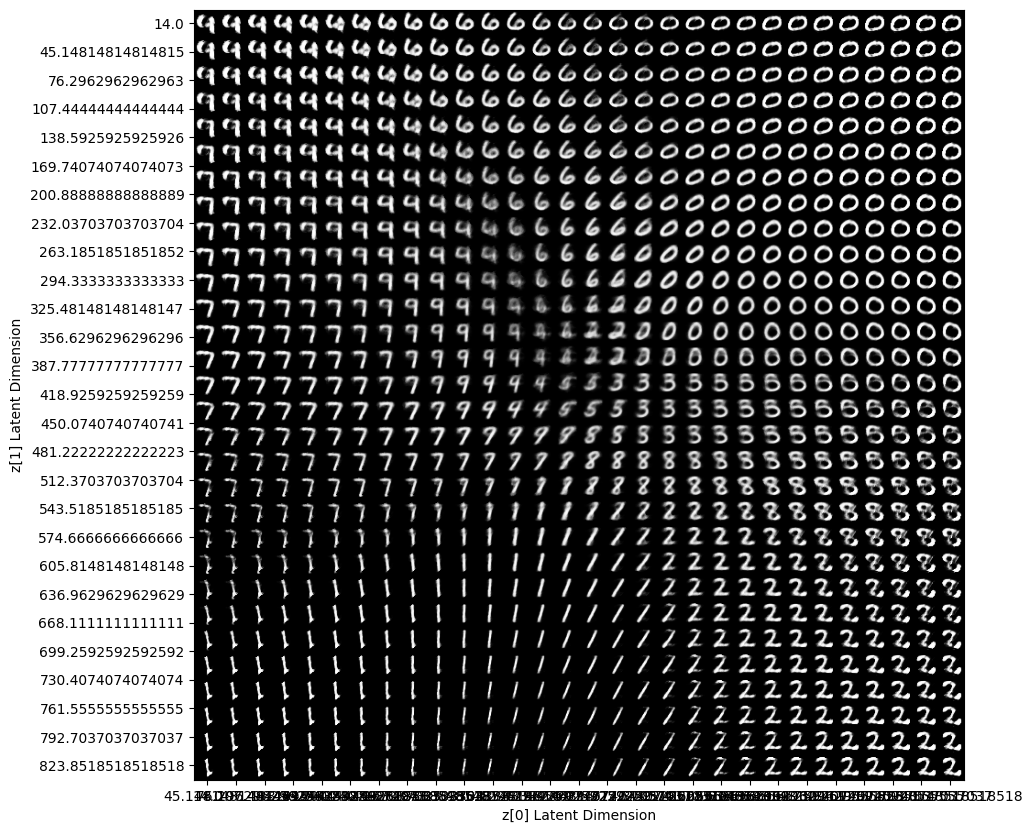

In [84]:
generate_manifold(decoder)

79/79 [==============================] - 1s 6ms/step


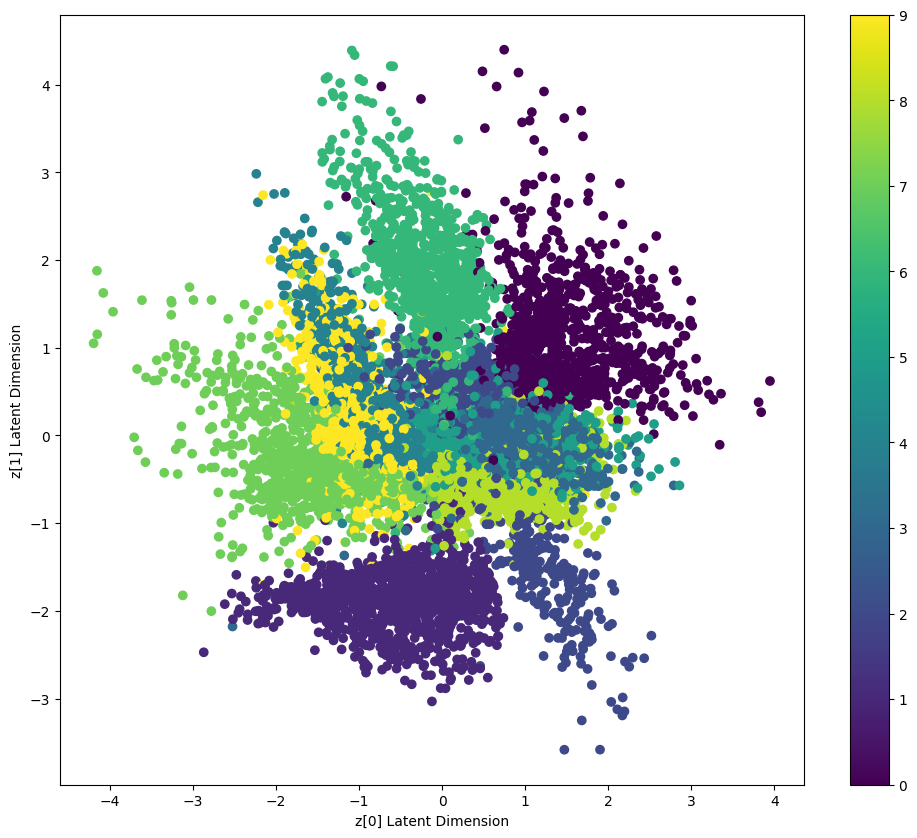

In [85]:
plot_digits(X_test, y, encoder)  # y for label coloring

Looks like by using the decoder on noisy data we can generate a completely new data!

## Your turn! 🚀

Assignment - [Denoising difussion model](../assignments/denoising-difussion-model.ipynb)

## Acknowledgments

Thanks to [Fazil T](https://github.com/lordsoffallen) for creating the open-source project [kaggle](https://www.kaggle.com/) for creating the open-source courses [Variantional Autoencoders(VAE)](https://www.kaggle.com/code/fazilbtopal/variantional-autoencoders-vae). They inspire the majority of the content in this chapter.